### Figure S11: Perturbation surface stress

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cf_xarray
import cartopy.crs as ccrs
import cmocean as cm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from dask.distributed import Client
import matplotlib.path as mpath
import scipy as sp
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame
import cartopy.feature as cft
from metpy.interpolate import cross_section
from pathlib import Path
import xgcm
from pyproj import Proj, transform
import pyproj
from datetime import datetime, timedelta
from xhistogram.xarray import histogram
import matplotlib.ticker as mticker
import intake

In [2]:
from dask.distributed import Client

client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33701/status,
Dashboard: /proxy/33701/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46039,Workers: 0
Dashboard: /proxy/33701/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33195,Total threads: 1
Dashboard: /proxy/46285/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:42101,


In [3]:
cat = intake.cat.access_nri
experiment = '01deg_jra55v140_iaf_cycle4' # the RYF90-91 experiment

exp_ds = cat[experiment]
exp_ds

,unique
filename,127845
path,131730
file_id,32
frequency,5
start_date,4324
end_date,4324
variable,335
variable_long_name,257
variable_standard_name,37
variable_cell_methods,6


In [4]:
grid_vars = ['xt_ocean','yt_ocean','st_edges_ocean','st_ocean']
coord_ds = exp_ds.search(
    variable=grid_vars, 
    file_id='ocean.1mon.nv:2.st_edges_ocean:76.st_ocean:75.xt_ocean:3600.yt_ocean:2700',
    frequency='1mon'
).to_dask(
    xarray_open_kwargs={
        'chunks' : "auto",
    }
)
xt_ocean = coord_ds['xt_ocean'].sel(xt_ocean=slice(-150,-50))
yt_ocean = coord_ds['yt_ocean'].sel(yt_ocean=slice(-80,-60))
st_ocean = coord_ds['st_ocean']

st_edges_ocean = coord_ds['st_edges_ocean']

In [5]:
aslat = slice(-75.5,-70)
aslon = slice(-120,-95)
latslice = slice(-76,-64.99) # make sure t and u cells have same lengths
lonslice = slice(-150,-70)
# Load data from perturbation experiments
pert_path = '/g/data/jk72/or6852/01deg_jra55_ryf_amundsen_perturbation_zonal200205/' # zonal
pert_path2 = '/g/data/jk72/or6852/01deg_jra55_ryf_amundsen_perturbation_both200205/' # both
cont_path = '/g/data/jk72/or6852/01deg_jra55_ryf_amundsen_perturbation_control/'

g=[]
g2 = []
q=[]
#q2 = []
for i in range(1000,1020):
    g.append(pert_path+'output'+str(i) + '/ocean/' + 'ocean_month.nc')
    g2.append(pert_path2+'output'+str(i) + '/ocean/' + 'ocean_month.nc')
    q.append(cont_path+'output'+str(i) + '/ocean/' + 'ocean_month.nc')

taux_pert = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)['tau_x'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))
taux_pert2 = xr.open_mfdataset(g2,combine='by_coords',chunks={'time': 1},decode_times = True)['tau_x'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))
taux_cont = xr.open_mfdataset(q,combine='by_coords',chunks={'time': 1},decode_times = True)['tau_x'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))

tauy_pert = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)['tau_y'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))
tauy_pert2 = xr.open_mfdataset(g2,combine='by_coords',chunks={'time': 1},decode_times = True)['tau_y'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))
tauy_cont = xr.open_mfdataset(q,combine='by_coords',chunks={'time': 1},decode_times = True)['tau_y'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))

temp_pert = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)['temp'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load() - 273.15
temp_pert2 = xr.open_mfdataset(g2,combine='by_coords',chunks={'time': 1},decode_times = True)['temp'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load() - 273.15
temp_cont = xr.open_mfdataset(q,combine='by_coords',chunks={'time': 1},decode_times = True)['temp'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load() - 273.15

salt_pert = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)['salt'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load()
salt_pert2 = xr.open_mfdataset(g2,combine='by_coords',chunks={'time': 1},decode_times = True)['salt'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load()
salt_cont = xr.open_mfdataset(q,combine='by_coords',chunks={'time': 1},decode_times = True)['salt'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load()


In [6]:
# Load grid variables: ht, area_t
ht = xr.open_dataset(pert_path+'output1000/ocean/ocean_grid.nc')['ht'].sel(yt_ocean = latslice).sel(xt_ocean = lonslice)
hu = xr.open_dataset(pert_path+'output1000/ocean/ocean_grid.nc')['hu'].sel(yu_ocean = latslice).sel(xu_ocean = lonslice)
area_t = xr.open_dataset(pert_path+'output1000/ocean/ocean_grid.nc')['area_t'].sel(yt_ocean = latslice).sel(xt_ocean = lonslice).fillna(0)
area_u = xr.open_dataset(pert_path+'output1000/ocean/ocean_grid.nc')['area_u'].sel(yu_ocean = latslice).sel(xu_ocean = lonslice).fillna(0)

In [10]:
# Load RYF winds + RYF perturbed winds:
ryf_u = xr.open_dataset('/g/data/jk72/or6852/amundsen_perturbation_forcing/pert.RYF.u_10.1990_1991.nc')['uas_10m'].sel(longitude = slice(205,305)).sel(latitude = slice(-77,-61)).mean('time')
ryf_uc = xr.open_dataset('/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.u_10.1990_1991.nc')['uas_10m'].sel(longitude = slice(205,305)).sel(latitude = slice(-77,-61)).mean('time')

ryf_v = xr.open_dataset('/g/data/jk72/or6852/amundsen_perturbation_forcing/pert.RYF.v_10.1990_1991.nc')['vas_10m'].sel(longitude = slice(205,305)).sel(latitude = slice(-77,-61)).mean('time')
ryf_vc = xr.open_dataset('/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.v_10.1990_1991.nc')['vas_10m'].sel(longitude = slice(205,305)).sel(latitude = slice(-77,-61)).mean('time')

ryf_v = ryf_v.assign_coords(longitude = ryf_v.longitude-360)
ryf_vc = ryf_vc.assign_coords(longitude = ryf_vc.longitude-360)

In [11]:
ht_large = xr.open_dataset(pert_path+'output1000/ocean/ocean_grid.nc')['ht'].sel(yt_ocean = slice(-77,-60)).sel(xt_ocean = slice(-160,-50))


In [13]:
# Calculate curl

In [15]:
dyu = xr.open_dataset(pert_path+'output1000/ocean/ocean_grid.nc')['dyu'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))
dxu = xr.open_dataset(pert_path+'output1000/ocean/ocean_grid.nc')['dxu'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))

In [16]:
# use dyu from above, because otherwise the nans from land spread:
phi = 7.292e-5     # Earth's rotation rate; in radians/s
Rearth = 6371e3  # Earth's radius; in m
f = 2 * phi * np.sin(np.deg2rad(dyu.yu_ocean)) # convert lat in radians
f = f.rename('Coriolis')
f.attrs['long_name'] = 'Coriolis parameter'
f.attrs['units'] = 's-1'
f.attrs['coordinates'] = 'geolon_c geolat_c'

inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=1))
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))

In [17]:
# fill land with zeros:
tauy_f = tauy_pert/f
tauy_f = tauy_f.fillna(0)
taux_f = taux_pert/f
taux_f = taux_f.fillna(0)

tauy_fb = tauy_pert2/f
tauy_fb = tauy_fb.fillna(0)
taux_fb = taux_pert2/f
taux_fb = taux_fb.fillna(0)

tauy_fc = tauy_cont/f
tauy_fc = tauy_fc.fillna(0)
taux_fc = taux_cont/f
taux_fc = taux_fc.fillna(0)

# compute derivatives:
d_dx_tauyf = (tauy_f - np.roll(tauy_f, 1, axis=2))*inverse_dxtn
d_dy_tauxf = (taux_f - np.roll(taux_f, 1, axis=1))*inverse_dyte
d_dx_tauyfb = (tauy_fb - np.roll(tauy_fb, 1, axis=2))*inverse_dxtn
d_dy_tauxfb = (taux_fb - np.roll(taux_fb, 1, axis=1))*inverse_dyte
d_dx_tauyfc = (tauy_fc - np.roll(tauy_fc, 1, axis=2))*inverse_dxtn
d_dy_tauxfc = (taux_fc - np.roll(taux_fc, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
d_dx_tauyf = 0.5 * (d_dx_tauyf + np.roll(d_dx_tauyf, 1, axis=1))
d_dy_tauxf = 0.5 * (d_dy_tauxf + np.roll(d_dy_tauxf, 1, axis=2))
d_dx_tauyfb = 0.5 * (d_dx_tauyfb + np.roll(d_dx_tauyfb, 1, axis=1))
d_dy_tauxfb = 0.5 * (d_dy_tauxfb + np.roll(d_dy_tauxfb, 1, axis=2))
d_dx_tauyfc = 0.5 * (d_dx_tauyfc + np.roll(d_dx_tauyfc, 1, axis=1))
d_dy_tauxfc = 0.5 * (d_dy_tauxfc + np.roll(d_dy_tauxfc, 1, axis=2))

# compute curl:
curl_tauf = d_dx_tauyf - d_dy_tauxf
curl_tauf = curl_tauf.load()
curl_taufb = d_dx_tauyfb - d_dy_tauxfb
curl_taufb = curl_taufb.load()
curl_taufc = d_dx_tauyfc - d_dy_tauxfc
curl_taufc = curl_taufc.load()

In [7]:
# Plot parametres: define projection and boundary path, landmask
xt2d = xt_ocean.expand_dims({'yt_ocean':yt_ocean})
yt2d = yt_ocean.expand_dims({'xt_ocean':xt_ocean})

def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """
    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[1, ::-1],  latitudes[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[:, 1],     latitudes[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

# Eastern Amundsen
midlon = -107.5
maxlon = -95
minlon = -120
minlat = -75.609
maxlat = -70.509
midlat = (minlat + maxlat)/2
lons = xt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = yt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)}).T
boundary_path_pibl = make_boundary_path(lons, lats)
extent_pibl = [minlon,maxlon,minlat,maxlat]
projection_pibl = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)


# West Antarctica
midlon = -105
maxlon = -70
minlon = -140
minlat = -76
maxlat = -64
midlat = (minlat + maxlat)/2
lons = xt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = yt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)}).T
boundary_path_wa = make_boundary_path(lons, lats)
extent_wa = [minlon,maxlon,minlat,maxlat]
projection_wa = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

In [8]:
# Define for plotting
land_u = xr.where(np.isnan(hu.rename('land')), 1, np.nan)
land = xr.where(np.isnan(ht.rename('land')), 1, np.nan)
land100 = xr.where(np.isnan(ht.where(ht>100).rename('land')), 1, np.nan)

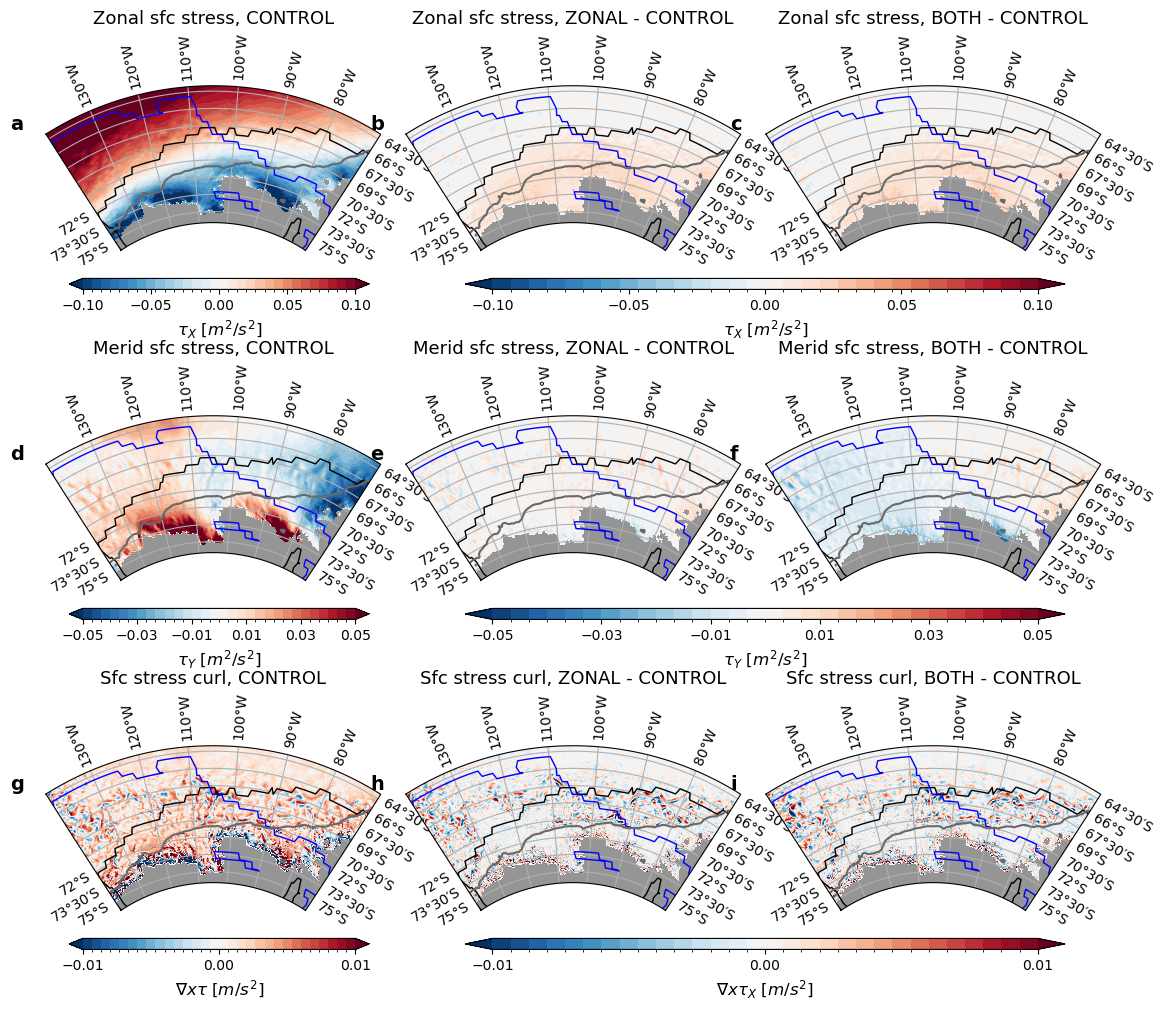

In [18]:
fig= plt.figure(figsize=(12,11))
for i in range(9):
    ax1 = plt.axes([0.05+(i%3)*0.3,0.65-np.floor(i/3)*0.3,0.28,0.28],projection=projection_wa)
    ax1.set_extent(extent_wa, crs=ccrs.PlateCarree())
    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.bottom_labels = False
    gl.left_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    ax1.set_boundary(boundary_path_wa, transform=ccrs.PlateCarree())


    land.plot(ax=ax1,cmap='Greys',add_colorbar=False, transform=ccrs.PlateCarree())
    (ryf_u-ryf_uc).plot.contour(ax=ax1,levels=[0],colors='k',linewidths=1,transform=ccrs.PlateCarree())
    (ryf_v-ryf_vc).plot.contour(ax=ax1,levels=[-0.01],colors='b',linewidths=1,linestyles='solid',transform=ccrs.PlateCarree())
    ht.sel(xt_ocean = slice(-130,-80)).sel(yt_ocean = slice(-73.2,-69)).plot.contour(ax=ax1,levels=[1000],linewidths=1.5,colors='dimgrey', transform=ccrs.PlateCarree())
    ht.sel(xt_ocean = slice(-150,-130)).sel(yt_ocean = slice(-75,-72)).plot.contour(ax=ax1,levels=[1000],linewidths=1.5,colors='dimgrey', transform=ccrs.PlateCarree())
    ht_large.sel(xt_ocean = slice(-80,-60)).sel(yt_ocean = slice(-70,-62)).plot.contour(ax=ax1,levels=[1000],linewidths=1.5,colors='dimgrey', transform=ccrs.PlateCarree())
    #ht.sel(xt_ocean = slice(-120,-100)).sel(yt_ocean = slice(-72,-70)).plot.contour(ax=ax1,levels=[600],linewidths=1.5,colors='dimgrey', transform=ccrs.PlateCarree())
    #axin1 = plt.axes([0.04,0.52,0.43,0.01])
#cb=plt.colorbar(p1,cax=axin1,ticks=np.arange(0,1.2,.2),orientation='horizontal',aspect = 50)
#cb.set_label('Zonal wind [$m/s$]',fontsize=14)
#cb.tick_params('y', labelsize=14)
#cb.set_ticks(np.arange(0,1.2,.2), labels=np.round(np.arange(0,1.2,.2),1),fontsize=12)

    ax1.text(-145,-62,chr(ord('a') + i),color='k',fontsize=14,fontweight='bold',transform=ccrs.PlateCarree())
    if i==0:
        cf = taux_cont[48:,:,:].mean('time').plot(ax=ax1, levels = np.linspace(-0.1,0.1,31),transform=ccrs.PlateCarree(), add_colorbar = False, extend='both')
        ax1.set_title('Zonal sfc stress, CONTROL', fontsize=13)
        axin = plt.axes([0.07,0.68,0.25,0.01])
        cb=plt.colorbar(cf,cax=axin,ticks=np.arange(-.1,0.15,.05),orientation='horizontal',aspect = 50)
        cb.set_label(r'$\tau_X$ [$m^2/s^2$]',fontsize=12)
    elif i==1:
        cf = (taux_pert-taux_cont)[48:,:,:].mean('time').plot(ax=ax1, levels = np.linspace(-0.1,0.1,31),transform=ccrs.PlateCarree(), add_colorbar = False)
        ax1.set_title('Zonal sfc stress, ZONAL - CONTROL', fontsize=13)
    elif i==2:
        cf = (taux_pert2-taux_cont)[48:,:,:].mean('time').plot(ax=ax1, levels = np.linspace(-0.1,0.1,31),transform=ccrs.PlateCarree(), add_colorbar = False,extend='both')
        ax1.set_title('Zonal sfc stress, BOTH - CONTROL', fontsize=13)
        axin = plt.axes([0.4,0.68,0.5,0.01])
        cb=plt.colorbar(cf,cax=axin,ticks=np.arange(-.1,0.15,.05),orientation='horizontal',aspect = 50)
        cb.set_label(r'$\tau_X$ [$m^2/s^2$]',fontsize=12)
        #cb.tick_params('y', labelsize=14)
        #cb.set_ticks(np.arange(0,1.2,.2), labels=np.round(np.arange(0,1.2,.2),1),fontsize=12)
    elif i==3:
        cf = tauy_cont[48:,:,:].mean('time').plot(ax=ax1, levels = np.linspace(-0.05,0.05,31),transform=ccrs.PlateCarree(), add_colorbar = False, extend='both')
        ax1.set_title('Merid sfc stress, CONTROL', fontsize=13)
        axin = plt.axes([0.07,0.38,0.25,0.01])
        cb=plt.colorbar(cf,cax=axin,ticks=np.arange(-.05,0.07,.02),orientation='horizontal',aspect = 50)
        cb.set_label(r'$\tau_Y$ [$m^2/s^2$]',fontsize=12)
    elif i==4:
        (tauy_pert-tauy_cont)[48:,:,:].mean('time').plot(ax=ax1, levels = np.linspace(-0.05,0.05,31),transform=ccrs.PlateCarree(), add_colorbar = False)
        ax1.set_title('Merid sfc stress, ZONAL - CONTROL', fontsize=13)
    elif i==5:
        cf = (tauy_pert2-tauy_cont)[48:,:,:].mean('time').plot(ax=ax1, levels = np.linspace(-0.05,0.05,31),transform=ccrs.PlateCarree(), add_colorbar = False, extend='both')
        ax1.set_title('Merid sfc stress, BOTH - CONTROL', fontsize=13)
        axin = plt.axes([0.4,0.38,0.5,0.01])
        cb=plt.colorbar(cf,cax=axin,ticks=np.arange(-.05,0.07,.02),orientation='horizontal',aspect = 50)
        cb.set_label(r'$\tau_Y$ [$m^2/s^2$]',fontsize=12)
    elif i==6:
        cf = curl_taufc[48:,:,:].mean('time').plot(ax=ax1, levels = np.linspace(-0.01,0.01,31),transform=ccrs.PlateCarree(), add_colorbar = False, extend='both')
        ax1.set_title('Sfc stress curl, CONTROL', fontsize=13)
        axin = plt.axes([0.07,0.08,0.25,0.01])
        cb=plt.colorbar(cf,cax=axin,ticks=np.arange(-.01,0.02,.01),orientation='horizontal',aspect = 50)
        cb.set_label(r'$\nabla x \tau$ [$m/s^2$]',fontsize=12)
    elif i==7:
        (curl_tauf - curl_taufc)[48:,:,:].mean('time').plot(ax=ax1, levels = np.linspace(-0.01,0.01,31),transform=ccrs.PlateCarree(), add_colorbar = False)
        ax1.set_title('Sfc stress curl, ZONAL - CONTROL', fontsize=13)
    elif i==8:
        cf = (curl_taufb - curl_taufc)[48:,:,:].mean('time').plot(ax=ax1, levels = np.linspace(-0.01,0.01,31),transform=ccrs.PlateCarree(), add_colorbar = False, extend='both')
        ax1.set_title('Sfc stress curl, BOTH - CONTROL', fontsize=13)
        axin = plt.axes([0.4,0.08,0.5,0.01])
        cb=plt.colorbar(cf,cax=axin,ticks=np.arange(-.01,0.02,.01),orientation='horizontal',aspect = 50)
        cb.set_label(r'$\nabla x \tau_X$ [$m/s^2$]',fontsize=12)

#plt.savefig('/home/581/or6852/plots/figures/supplementary_pert_sfc_stress_v2.png',dpi=300)